In [57]:
## Functions for Q2
from scipy import stats,integrate
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import time

K = 2775
St = 2775
delta_t = 1
sigma = 0.15
r = 0.0278
y = 0.0189
t1 = 2
t2 = 1
seq = [10**3, 10**4, 10**5, 10**6]

def bare_bone_mc_normal(size_seq):
    '''Generate a dictionary of random normal series with various length sequence'''
    rand_dict = {}
    for n in size_seq:
        np.random.seed(123)
        rand_dict[n] = np.random.normal(size=n)
    return rand_dict


def simulate_price(x, St=2775, delta_t=1, sigma=0.15, r=0.0278, y=0.0189):
    '''Simulate price using random number series x'''
    return St * np.exp((r - y - sigma**2 / 2) * delta_t + sigma * np.sqrt(delta_t) * x)


def sample_stats(sample_dict, max_min=False, output=[]):
    '''Compute sample statistics'''
    stats_df = pd.DataFrame(columns=sample_dict.keys())
    for key in sample_dict:
        stats_df.loc['mean', key] = np.mean(sample_dict[key])
        stats_df.loc['std dev', key] = np.std(sample_dict[key])
        stats_df.loc['log mean', key] = np.mean(np.log(sample_dict[key]))
        stats_df.loc['log variance', key] = np.var(np.log(sample_dict[key]))
        if max_min:
            stats_df.loc['max', key] = max(sample_dict[key])
            stats_df.loc['min', key] = min(sample_dict[key])
    if not output:
        return stats_df
    else:
        return stats_df.loc[output, :]


def transformation(params, *args):
    '''Moment match algorithm to determine parameters for a tranform series'''
    x, St, delta_t, sigma, r, y, mean, var = args
    xp = params[0] + params[1] * x
    ST_p = simulate_price(xp)
    return [ST_p.mean() - mean, np.log(ST_p).var() - var]


def risk_neutral_put(ST, K=2775, delta_t=1, r=0.0278):
    '''Computes risk neural put option price given ST'''
    payoff = list(map(lambda x: (K - x) if K > x else 0, ST))
    price=np.exp(- r * delta_t) * np.mean(payoff)
    error=np.exp(- r * delta_t) * np.std(payoff) / np.sqrt(len(ST))
    return price, error, payoff


def antithetic(x, St=2775):
    '''Antithetic method for variance reduction'''
    x_anti = np.multiply(x, -1)
    ST = simulate_price(x, St)
    ST_anti = simulate_price(x_anti, St)
    PT = 0.5 * np.add(risk_neutral_put(ST)[2], risk_neutral_put(ST_anti)[2])
    return PT


def efficiency_ratio(var1, var2, t1, t2):
    '''Ratio tests between Monte Carlo methods'''
    return var1 * t1 / (var2 * t2)


def finite_diff_delta(x, option_payoff, St, epsilon, method, anti=False):
    '''
    x: (list) a list of random variables
    option_payoff: (function) pass in a payoff function, i.e. bs put
    St: (float) S0 value
    epsilon: (float) a number of bump size
    method: (string) delta plus, minus or center
    anti: (boolean) antithetic variates method

    Return: (float) delta of some asset prices using finite difference.
    '''
    ST = simulate_price(x, St)
    Pt = option_payoff(ST)[0] if not anti else antithetic(x, St)
    ST_delta = epsilon * St
    if method == 'p':
        St2 = St * (1 + epsilon)
        ST2 = simulate_price(x, St2)
        Pt2 = option_payoff(ST2)[0] if not anti else antithetic(x, St2)
    elif method == 'm':
        St2 = St * (1 - epsilon)
        ST2 = simulate_price(x, St2)
        Pt2 = option_payoff(ST2)[0] if not anti else antithetic(x, St2)
        ST_delta *= -1
    elif method == 'c':
        St1 = St * (1 - epsilon)
        St2 = St * (1 + epsilon)
        ST1 = simulate_price(x, St1)
        ST2 = simulate_price(x, St2)
        Pt = option_payoff(ST1)[0] if not anti else antithetic(x, St1)
        Pt2 = option_payoff(ST2)[0] if not anti else antithetic(x, St2)
        ST_delta *= 2
    return (Pt2 - Pt) / ST_delta


def finite_diff_gamma(x, option_payoff, St, epsilon, method='c'):
    '''Returns gamma of some asset prices using finite difference'''
    ST = simulate_price(x, St)
    ST1 = simulate_price(x, St * (1 - epsilon))
    ST2 = simulate_price(x, St * (1 + epsilon))
    Pt, Pt1, Pt2 = [option_payoff(s)[0] for s in [ST, ST1, ST2]]
    ST_delta = epsilon * St
    return (Pt1 + Pt2 - 2 * Pt) / (ST_delta ** 2)


def bs_delta_gamma(S, K, T, r, y, sigma):
    '''Returns BS greeks associated with a put option'''
    d1=((np.log(S/K)+(r-y)*(T))/(sigma*np.sqrt(T)))+sigma*np.sqrt(T)/2
    d2=((np.log(S/K)+(r-y)*(T))/(sigma*np.sqrt(T)))-sigma*np.sqrt(T)/2
    Delta = norm.cdf(d1) - 1
    Gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return Delta, Gamma

In [28]:
# a)
rand_dict = bare_bone_mc_normal(seq)
ST = {key:simulate_price(rand_dict[key]) for key in rand_dict}

def SQP_MC(S_T, K=2775,delta_t=1, r=0.0278):
    "Simulate price of Sqrt Put option given terminal stock price"
    payoff = list(map(lambda x:np.sqrt(K)*(np.sqrt(K)-np.sqrt(x)) if K>x else 0,S_T))
    price=np.exp(-r*delta_t)*np.mean(payoff)
    error=np.exp(-r*delta_t)*np.std(payoff)/np.sqrt(len(S_T))
    return price, error, payoff

SQP_MC_res = {key:SQP_MC(ST[key]) for key in ST} # Store MC result
SQP_MC_0 = {key:SQP_MC_res[key][0] for key in ST}
SQP_err = {key:SQP_MC_res[key][1] for key in ST}
SQP_payoff = {key:SQP_MC_res[key][2] for key in ST}

In [29]:
print("SQP price:",SQP_MC_0)
print("std:",SQP_err)
#print("payoff:",SQP_payoff)
np.mean(SQP_payoff[100000])


SQP price: {1000: 82.20890233508725, 10000: 77.7203323809961, 100000: 78.53443763679773, 1000000: 78.58844142540487}
std: {1000: 3.634331814286209, 10000: 1.1088621803687473, 100000: 0.3526577419621708, 1000000: 0.11174624684368965}


80.74832546397934

In [30]:
# b)
def BS(security,K,S,r,y,sigma,T=1,t=0):
    d1=((np.log(S/K)+(r-y)*(T-t))/(sigma*np.sqrt(T-t)))+sigma*np.sqrt(T-t)/2
    d2=((np.log(S/K)+(r-y)*(T-t))/(sigma*np.sqrt(T-t)))-sigma*np.sqrt(T-t)/2
    AONC = S*np.exp(-y*(T-t))*stats.norm.cdf(d1)
    CONC = np.exp(-r*(T-t))*stats.norm.cdf(d2)
    AONP = S*np.exp(-y*(T-t))*stats.norm.cdf(-d1)
    CONP = np.exp(-r*(T-t))*stats.norm.cdf(-d2)
    BSC = AONC - K*CONC
    BSP = K*CONP - AONP 
    if security == "BSC":
        return BSC
    elif security == "BSP": 
        return BSP
    elif security == "CONC": 
        return CONC
    elif security == "CONP":
        return CONP
    elif security == "AONC":
        return AONC
    elif security == "AONP":
        return AONP
    elif security == "d1":
        return d1
    elif security == "d2":
        return d2

alpha = .5
y_eff = r - alpha*((r-y)+(alpha-1)*.5*(sigma**2))
# Transform to power option 
SQP_BS = np.sqrt(k)*BS("BSP",K=np.sqrt(k),S=np.sqrt(St),r=r,y=y_eff,sigma=abs(alpha)*sigma,T=delta_t)
t_stat = {key:(SQP_MC_0[key]-SQP_BS)/SQP_err[key] for key in rand_dict}
print(SQP_BS)
print(t_stat)

78.60835395411857
{1000: 0.9907043618899258, 10000: -0.8008403468383822, 100000: -0.20959788635170734, 1000000: -0.17819416111180206}


In [31]:
# c)
def BL_payoff(S=2775, Kstar = 2775, sigma=0.15, r=0.0278, y=0.0189,T=1, t=0):
    def integrand(K,*args):
        d1=((np.log(S/K)+(r-y)*(T-t))/(sigma*np.sqrt(T-t)))+sigma*np.sqrt(T-t)/2
        d2=((np.log(S/K)+(r-y)*(T-t))/(sigma*np.sqrt(T-t)))-sigma*np.sqrt(T-t)/2
        AONP = S*np.exp(-y*(T-t))*stats.norm.cdf(-d1)
        CONP = np.exp(-r*(T-t))*stats.norm.cdf(-d2)
        BSP = K*CONP - AONP 
        F_dd = .25*np.sqrt(K)*(Kstar**(-1.5))
        func = BSP*F_dd
        return func
    args= (S,Kstar,sigma,r,y,T,t)
    result = integrate.quad(integrand, 0, Kstar, args=args)
    return result

BL_payoff()    
        

(2.9837078097245016, 2.913481465089372e-11)

In [32]:
# d)
BSP_MC_res = {key:risk_neutral_put(ST[key]) for key in ST} # Store MC result
BSP_MC_0 = {key:BSP_MC_res[key][0] for key in ST}
BSP_err = {key:BSP_MC_res[key][1] for key in ST}
BSP_payoff = {key:BSP_MC_res[key][2] for key in ST}
BSP_MC_0

{1000: 157.01977499764973,
 10000: 148.64675432442846,
 100000: 150.17559063107427,
 1000000: 150.26175218336903}

In [33]:
mc_cov = {key:np.cov(np.stack((SQP_payoff[key],BSP_payoff[key]))) for key in SQP_payoff}
mc_corr = {key:np.corrcoef(np.stack((SQP_payoff[key],BSP_payoff[key]))) for key in SQP_payoff}
print("cov:",mc_cov)
print("corr:",mc_corr)

cov: {1000: array([[13977.53011574, 26226.31261844],
       [26226.31261844, 49244.20491994]]), 10000: array([[13000.05972535, 24449.79860258],
       [24449.79860258, 46016.23526062]]), 100000: array([[13147.94749279, 24714.14969962],
       [24714.14969962, 46488.24510381]]), 1000000: array([[13201.19051816, 24808.08469007],
       [24808.08469007, 46653.51790614]])}
corr: {1000: array([[1.       , 0.9996419],
       [0.9996419, 1.       ]]), 10000: array([[1.        , 0.99964793],
       [0.99964793, 1.        ]]), 100000: array([[1.        , 0.99964343],
       [0.99964343, 1.        ]]), 1000000: array([[1.        , 0.99964198],
       [0.99964198, 1.        ]])}


In [34]:
# e)
def cvar_MC(S_T, alpha, K=2775,delta_t=1, r=0.0278):
    payoff = list(map(lambda x:(np.sqrt(K) - alpha*(np.sqrt(K)+np.sqrt(x)))*(np.sqrt(K)-np.sqrt(x)) if K>x else 0,S_T))
    price=np.exp(-r*delta_t)*np.mean(payoff)
    error=np.exp(-r*delta_t)*np.std(payoff)/np.sqrt(len(S_T))
    return price, error, payoff

cvar_MC_res = {key:cvar_MC(ST[key],.5) for key in ST} # Store MC result
cvar_MC_0 = {key:cvar_MC_res[key][0] for key in ST}
cvar_err = {key:cvar_MC_res[key][1] for key in ST}
cvar_payoff = {key:cvar_MC_res[key][2] for key in ST}

In [11]:
# compare error
err_diff = {key:SQP_err[key]-cvar_err[key] for key in SQP_err}
# efficiency
cvar_eff = {key:efficiency_ratio(BSP_err[key]**2, cvar_err[key]**2,1,2) for key in cvar_err}
print(cvar_MC_0)
print(err_diff)
print(cvar_eff)

{1000: 3.699014836262418, 10000: 3.396955218781935, 100000: 3.4466423212606503, 1000000: 3.4575653337204018}
{1000: 3.391757757071299, 10000: 1.0371844029767237, 100000: 0.3296713245453414, 1000000: 0.10443663805862108}
{1000: 395.41682532556376, 10000: 423.5667142737873, 100000: 416.1208362132884, 1000000: 412.9704019436556}


In [74]:
# f)
# i)
# Numerical derivative of closed form SQP
def SQP_delta_gamma(S, K, T, r, y, sigma):
    SQP_epsilon = 0.00000001
    SQP0 = np.sqrt(k)*BS("BSP",K,np.sqrt(S),r,y,sigma,T)
    SQP1 = np.sqrt(k)*BS("BSP",K,np.sqrt(S-SQP_epsilon),r,y,sigma,T)
    SQP2 = np.sqrt(k)*BS("BSP",K,np.sqrt(S+SQP_epsilon),r,y,sigma,T)
    Delta = (SQP2 - SQP1)/(2*SQP_epsilon)
    Gamma = (SQP1+SQP2-2*SQP0)/(SQP_epsilon**2)
    return Delta, Gamma

SQP_delta_gamma(K=np.sqrt(K),S=St,r=r,y=y_eff,sigma=abs(alpha)*sigma,T=delta_t)
#SQP2 = np.sqrt(k)*BS("BSP",K=np.sqrt(k),S=np.sqrt(St+SQP_epsilon),r=r,y=y_eff,sigma=abs(alpha)*sigma,T=delta_t)
#SQP_delta

(-0.23201138787953823, -3979.0393202565606)

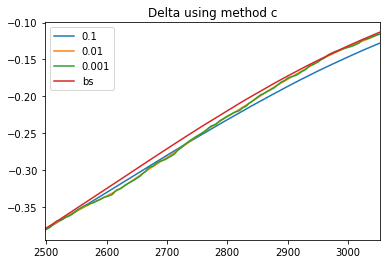

In [75]:
# plot delta
epsilon = [0.1, 0.01, 0.001]
method = ['c']
sample_size = 1000
S0 = np.linspace(0.9 * St, 1.1 * St, sample_size)
delta_bs = []
gamma_bs = []
delta = {}
for me in method:
    me_df = pd.DataFrame(columns=epsilon)
    for S in S0:
         # finite difference
        for e in epsilon:
             me_df.loc[S, e] = finite_diff_delta(rand_dict[1000],SQP_MC, S, e, me)
        # bs delta and gamma
        delta_bs.append(SQP_delta_gamma(S, np.sqrt(K), delta_t, r, y_eff, abs(alpha)*sigma)[0])
    me_df.loc[:, 'bs'] = delta_bs
    delta["delta_{0}".format(me)] = me_df.sort_index()
    delta["delta_{0}".format(me)].plot(title="Delta using method %s" % me)
    plt.show()

In [70]:
# ii) Plot Gamma
gamma_bs = []
gamma_df = pd.DataFrame(columns=epsilon)
for S in S0:
    # finite difference
    for e in epsilon:
        gamma_df.loc[S, e] = finite_diff_gamma(rand_dict[1000], S, e)
    # bs gamma
    gamma_bs.append(bs_delta_gamma(S, K, delta_t, r, sigma)[1])
gamma_df.loc[:, 'bs'] = gamma_bs
gamma_df = gamma_df.sort_index()
gamma_df.plot(title="Gamma function")
plt.show()

-0.7377421628396007

In [64]:
finite_diff_delta(rand_dict[1000],SQP_MC, 3000, .1, 'c')

-0.14667227031011976